In [4]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import nibabel as nib
import numpy as np
from nilearn.input_data import NiftiMasker
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.svm import LinearSVC
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from brainiak.utils.fmrisim import _double_gamma_hrf as hrf_func
from brainiak.utils import fmrisim as sim

sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

In [49]:
# Set the variables
sub = 'sub-01';

vdc_data_dir = "/Users/scotti.5/Downloads/vdc/"
vdc_n_runs = 3
vdc_TR = 1.5
vdc_TRs_run = 310

# Preset the variable size
stim_label = [];
stim_label_allruns = [];
for run in range(1, vdc_n_runs+1):
    
    # Specify the input variables
    in_file = os.path.join(vdc_data_dir,sub,'ses-day2','design_matrix','%s_localizer_0%d.mat' % (sub, run))
    
    # Load in data from matlab
    stim_label = scipy.io.loadmat(in_file);
    stim_label = np.array(stim_label['data']);

    # Store the data
    if run == 1:
        stim_label_allruns = stim_label;
    else:       
        stim_label_allruns = np.hstack((stim_label_allruns, stim_label))

print("Loaded labels for", sub)

Loaded labels for sub-01


In [16]:
def load_vdc_stim_labels(vdc_data_dir, subject_id):
    stim_label = [];
    stim_label_concatenated = [];
    for run in range(1, vdc_n_runs+1):
        in_file = os.path.join(vdc_data_dir,subject_id,'ses-day2','design_matrix','%s_localizer_0%d.mat' % 
                               (subject_id, run))
        # Load in data from matlab
        stim_label = scipy.io.loadmat(in_file);
        stim_label = np.array(stim_label['data']);

        # Store the data
        if run == 1:
            stim_label_concatenated = stim_label;
        else:       
            stim_label_concatenated = np.hstack((stim_label_concatenated, stim_label))
    print("Loaded labels for", subject_id)
    return stim_label_concatenated

In [17]:
stim_label_allruns = load_vdc_stim_labels(vdc_data_dir, sub)

Loaded labels for sub-01


In [25]:
def label2TR(stim_label_allruns, vdc_n_runs, vdc_TR, vdc_TRs_run):
    _, events = stim_label_allruns.shape
    events_run = int(events / vdc_n_runs)

    # Preset the array with zeros
    stim_label_TR = np.zeros((vdc_TRs_run * 3, 1))

    # Cycle through the runs
    for run in range(vdc_n_runs):

        # Cycle through each element in a run
        for i in range(events_run):

            # What element in the concatenated timing file are we accessing
            time_idx = run * (events_run) + i

            # What is the time stamp
            time = stim_label_allruns[2, time_idx]

            # What TR does this timepoint refer to?
            TR_idx = int(time / vdc_TR) + (run * (vdc_TRs_run - 1))

            # Add the condition label to this timepoint
            stim_label_TR[TR_idx] = stim_label_allruns[0, time_idx]
    return stim_label_TR

In [26]:
stim_label_TR = label2TR(stim_label_allruns, vdc_n_runs, vdc_TR, vdc_TRs_run)

Text(0.5, 0, 'TR')

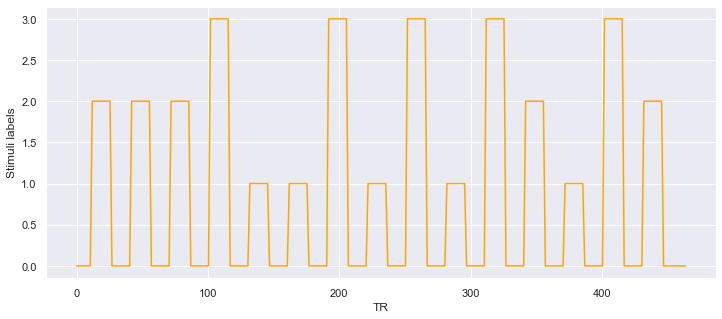

In [27]:
tr_time = np.arange(0, (vdc_TRs_run - 1) * 1.5 + 1, 1.5)

# Plot the data
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(tr_time, stim_label_TR[0:vdc_TRs_run, 0], c='orange')

ax.set_ylabel('Stimuli labels')
ax.set_xlabel('TR')

Text(0.5, 0, 'Time in secs')

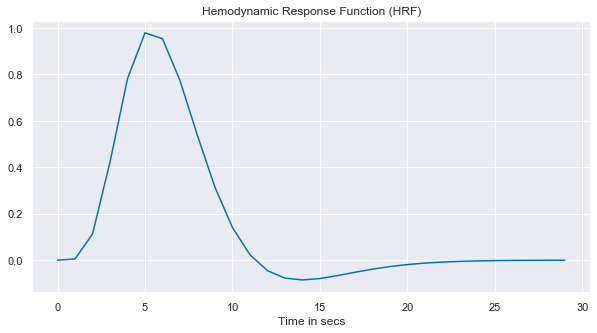

In [28]:
# Create an example HRF
hrf = hrf_func(temporal_resolution=1)

# Plot the canonical double gamma HRF
f, ax = plt.subplots(1,1, figsize = (10, 5))
ax.plot(range(30), hrf)

ax.set_title("Hemodynamic Response Function (HRF)")
ax.set_xlabel('Time in secs')

Text(0.5, 0, 'TRs')

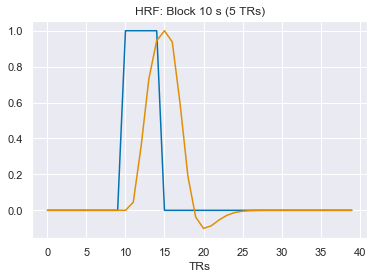

In [31]:
# Specify some parameters
trDuration = 2  # seconds
numTRs = 40 # How many TRs will you generate?
total_time = int(numTRs * trDuration)
temporal_res = 0.5 # 1/trDuration
stim_A = sim.generate_stimfunction(onsets=[20], 
                                   event_durations=[10], 
                                   total_time=total_time,
                                   temporal_resolution=temporal_res 
                                   )
plt.plot(stim_A)
plt.title('Stimulus Timing: Block 10 s (5 TRs)')
plt.xlabel('TRs')
signal_func_A = sim.convolve_hrf(stimfunction=stim_A,
                                 tr_duration=trDuration,
                                 temporal_resolution=temporal_res,
                                 scale_function=1,
                                 )
plt.plot(signal_func_A)
plt.title('HRF: Block 10 s (5 TRs)')
plt.xlabel('TRs')


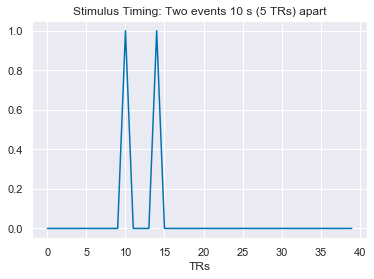

In [32]:
stim_B = sim.generate_stimfunction(onsets=[20,28],
                                   event_durations=[2,2], 
                                   total_time=total_time,
                                   temporal_resolution=temporal_res,
                                  )
plt.plot(stim_B)
plt.title('Stimulus Timing: Two events 10 s (5 TRs) apart')
plt.xlabel('TRs')
signal_func_B = sim.convolve_hrf(stimfunction=stim_B,
                                   tr_duration=2,
                                   temporal_resolution=temporal_res,
                                   scale_function=1,
                                   )

Text(0.5, 0, 'Time (seconds)')

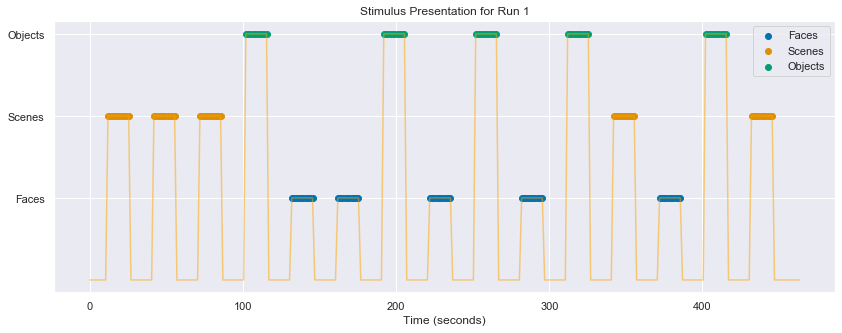

In [37]:
vdc_label_dict = {1: 'Faces', 2: 'Scenes', 3: 'Objects'}
n_conditions = len(vdc_label_dict)

cur_pals = sns.color_palette('colorblind', n_colors=n_conditions)

# Create a sequence of timepoints that a TR occurred on
tr_time = np.arange(0, (vdc_TRs_run - 1) * 1.5 + 1, 1.5)
time_vals = stim_label_allruns[2, 0:150]
labels = stim_label_allruns[0, 0:150]

f, ax = plt.subplots(1,1, figsize = (14, 5))
    
# plot the label for each condition
for i_cond in range(n_conditions): 
    label = list(vdc_label_dict.keys())[i_cond]
    temp_mask = label == labels
    ax.scatter(time_vals[temp_mask], labels[temp_mask], 
               color = cur_pals[i_cond], marker = 'o')
ax.legend(vdc_label_dict.values())
    
# plot the stimuli as a line 
# ax.plot(time_vals, labels, color = 'black', alpha = .5)
ax.plot(tr_time, stim_label_TR[0:vdc_TRs_run, 0], c='orange', alpha = .5)

ax.set_yticks(list(vdc_label_dict.keys()))
ax.set_yticklabels(vdc_label_dict.values())

ax.set_title('Stimulus Presentation for Run 1')
ax.set_xlabel('Time (seconds)')

In [39]:
vdc_hrf_lag = 4.5

print('Amount of time shift: %0.1f' % vdc_hrf_lag) # In seconds what is the lag between a stimulus onset and the peak bold response
shift_size = int(vdc_hrf_lag / vdc_TR)  # Convert the shift into TRs

# Create a function to shift the size
def shift_timing(label_TR, TR_shift_size):
    
    # Create a short vector of extra zeros
    zero_shift = np.zeros((TR_shift_size, 1))

    # Zero pad the column from the top
    label_TR_shifted = np.vstack((zero_shift, label_TR))

    # Don't include the last rows that have been shifted out of the time line
    label_TR_shifted = label_TR_shifted[0:label_TR.shape[0],0]
    
    return label_TR_shifted

# Apply the function
stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)

Amount of time shift: 4.5


In [52]:
roi_name = 'FFA'
vdc_all_ROIs=['FFA', 'PPA']

# Apply the function to pull out the mask data
epi_mask_data_all = load_vdc_masked_data(vdc_data_dir, sub, vdc_all_ROIs)

# Check the dimensionality of the data
print('voxel by TR matrix - shape: ', epi_mask_data_all[vdc_all_ROIs.index(roi_name)].shape)
print('label list - shape: ', stim_label_TR_shifted.shape)

Loaded FFA mask
Loading data from /Users/scotti.5/Downloads/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /Users/scotti.5/Downloads/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /Users/scotti.5/Downloads/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
Loaded PPA mask
Loading data from /Users/scotti.5/Downloads/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /Users/scotti.5/Downloads/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /Users/scotti.5/Downloads/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
voxel by TR matrix - shape:  (5519, 930)
label list - shape:  (930,)


In [51]:
def load_vdc_masked_data(directory, subject_name, mask_list):
    masked_data_all = [0] * len(mask_list)

    # Cycle through the masks
    for mask_counter in range(len(mask_list)):
        # load the mask for the corresponding ROI
        mask = load_vdc_mask(mask_list[mask_counter], subject_name)

        # Cycle through the runs
        for run in range(1, vdc_n_runs + 1):
            # load fMRI data 
            epi_data = load_vdc_epi_data(subject_name, run)
            # mask the data 
            epi_masked_data = mask_data(epi_data, mask)
            epi_masked_data = np.transpose(epi_masked_data)
            
            # concatenate data 
            if run == 1:
                masked_data_all[mask_counter] = epi_masked_data
            else:
                masked_data_all[mask_counter] = np.hstack(
                    (masked_data_all[mask_counter], epi_masked_data)
                )
    return masked_data_all

def load_vdc_mask(ROI_name, sub):
    """Load the mask for the VDC data 
    Parameters
    ----------
    ROI_name: string
    sub: string 
    
    Return
    ----------
    the requested mask
    """    
    assert ROI_name in vdc_all_ROIs
    maskdir = (vdc_data_dir + sub + "/preprocessed/masks/")
    # load the mask
    maskfile = (maskdir + sub + "_ventral_%s_locColl_to_epi1.nii.gz" % (ROI_name))
    mask = nib.load(maskfile)
    print("Loaded %s mask" % (ROI_name))
    return mask

def load_vdc_epi_data(sub, run):
    # Load MRI file (in Nifti format) of one localizer run
    epi_in = (vdc_data_dir + sub + 
              "/preprocessed/loc/%s_filtered2_d1_firstExampleFunc_r%d.nii" % (sub, run))
    epi_data = nib.load(epi_in)
    print("Loading data from %s" % (epi_in))
    return epi_data


def mask_data(epi_data, mask): 
    """mask the input data with the input mask 
    Parameters
    ----------
    epi_data
    mask
    
    Return
    ----------
    masked data
    """    
    nifti_masker = NiftiMasker(mask_img=mask)
    epi_masked_data = nifti_masker.fit_transform(epi_data);
    return epi_masked_data

In [53]:
def reshape_data(label_TR_shifted, masked_data_all):
    label_index = np.nonzero(label_TR_shifted)
    label_index = np.squeeze(label_index)
    # Pull out the indexes
    indexed_data = np.transpose(masked_data_all[:,label_index])
    nonzero_labels = label_TR_shifted[label_index] 
    return indexed_data, nonzero_labels

# Pull out the data from this ROI for these time points
roi_masked_data = epi_mask_data_all[vdc_all_ROIs.index(roi_name)]
bold_data, labels = reshape_data(stim_label_TR_shifted, roi_masked_data)

# What is the dimensionality of the data? We need the first dim to be the same
print('The %s has the dimensionality of: %d time points by %d voxels' % (roi_name, bold_data.shape[0], bold_data.shape[1]))

The FFA has the dimensionality of: 450 time points by 5519 voxels


In [54]:
# Get run ids (works similarity to cv_ids)
run_ids = stim_label_allruns[5,:] - 1 

# Select a run
holdout_run_ids = 0

# Make an index list with one run left out.
train_runs = run_ids != holdout_run_ids

def normalize(bold_data_, run_ids):
    """normalized the data within each run
    
    Parameters
    --------------
    bold_data_: np.array, n_stimuli x n_voxels
    run_ids: np.array or a list
    
    Return
    --------------
    normalized_data
    """
    scaler = StandardScaler()
    data = []
    for r in range(vdc_n_runs):
        data.append(scaler.fit_transform(bold_data_[run_ids == r, :]))
    normalized_data = np.vstack(data)
    return normalized_data

bold_data_normalized = normalize(bold_data, run_ids)

In [55]:
X_train = bold_data_normalized[train_runs,]
y_train = labels[train_runs]
X_test = bold_data_normalized[np.logical_not(train_runs),]
y_test = labels[np.logical_not(train_runs)]

In [56]:
X_train.shape

(300, 5519)

In [57]:
y_train.shape

(300,)

In [58]:
model = LinearSVC(C=1)

# Fit the model
model.fit(X_train, y_train)

# Compute your evaluation on the test set
score = model.score(X_test, y_test)
print('Accuracy = %s' % score)

Accuracy = 0.88
